In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random

---

## Define common functions

In [2]:
## read_data from result of control plane
def read_data(algos, row=4, width=1024, flowkey='dstIP,dstPort', epochs=['10', '20', '30'], dataset='equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/'):
    res = {}
    for algo in algos:
        res[algo] = []
        for epoch in epochs:
            path = f"../../result_cp/QuerySketch/{algo}/{dataset}"\
                    f"{flowkey}/row_{row}_width_{width}_level_1_epoch_{epoch}_count_1_seed_1/data.pkl"
            # print(algo, epoch)
            with open(path, 'rb') as f:
                ll = pickle.load(f)
            res[algo].append(ll)
            # print(ll[0])
    return res

In [3]:
## Define metric -> algos
def get_metrics_algos():
    metrics_algos = {}
    metrics_algos['hh'] = ['cm', 'cs']
    metrics_algos['card'] = ['hll', 'lc']
    metrics_algos['entropy'] = ['cm']
    return metrics_algos
metrics_algos = get_metrics_algos()

## Define algos -> metric
def get_algos_metrics():
    tmp = get_metrics_algos()
    algos_metrics = {}
    for m in tmp:
        for algo in tmp[m]:
            if algo not in algos_metrics:
                algos_metrics[algo] = [m]
            else:
                algos_metrics[algo].append(m)
    return algos_metrics
algos_metrics = get_algos_metrics()

general_metrics = ['univmon']

In [4]:
## Define mapping dictionary for index <---> metric
algos = ['univmon', 'cm', 'cs', 'hll', 'lc']
def get_metric_mapping(algos = ['univmon', 'cm', 'cs', 'hll']):
    mapping = {}
    for k in algos:
        mapping[k] = {}

    # UNIV: [true_entropy, sim_entropy, sim_entropy_error, true_card, sim_card, sim_card_error, ARE]
    mapping['univmon']['hh'] = 6
    mapping['univmon']['card'] = 5 
    mapping['univmon']['entropy'] = 2
    # cm: [entropy, entropy_est, relative_entropy_error, sim_ARE_error]
    mapping['cm']['hh'] = 3
    mapping['cm']['entropy'] = 2
    # cs: [sim_ARE_error]
    mapping['cs']['hh'] = 3
    mapping['cs']['entropy'] = 2
    # hll: [true_cardinality, sim_cardinality, sim_error]
    mapping['hll']['card'] = 2
    # lc: [true_cardinality, sim_cardinality, sim_error]
    mapping['lc']['card'] = 2
    return mapping
mapping = get_metric_mapping(algos)

---

## Define profiling functions

In [5]:
# get_data_from_pkl
# combine the flowkeys, datasets, epochs to a list
def get_result_from_pkl(algos = ['cm'], rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072],
                     measure_list = ['hh', 'entropy'], flowkeys = ["srcIP,srcPort", "dstIP,dstPort",], epochs = ['30'],
                     datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/']):
    # key: metric, row, width
    ret = {}
    for m in measure_list:
        ret[m] = {}
        for r in rows:
            ret[m][r] = {}
            for w in widths:
                ret[m][r][w] = []

    # print("get_result_from_pkl")
    for r in rows:
        # print("r", r)
        for w in widths:
            # print("w", w)
            for flowkey in flowkeys:
                for dataset in datasets:
                    tmp = read_data(algos, r, w, flowkey, epochs, dataset)
                    for algo in algos:
                        for measure in measure_list:
                            # epoch
                            for e in range(len(epochs)):
                                # ll = []
                                # raw data
                                for d in tmp[algo][e]:
                                    # ll.append(d[mapping[algo][measure]])
                                    # print(d[mapping[algo][measure]])
                                    # print(r, w, flowkey, dataset, algo, measure)
                                    ret[measure][r][w].append(d[mapping[algo][measure]])
                                # print(w, flowkey, measure, epochs[e], np.mean(ll))
    return ret

# # key: metric, row, width
# ret = get_data_from_pkl()
# print(ret['hh'][1][4096])

In [6]:
# get mean value for all list in the same row size & col size & metric
def get_mean_value(ret, rows = [1, 2, 3, 4, 5], measure_list = ['hh', 'entropy']):
    # key: metric, row
    # mean value of the same column 
    data = {}
    for m in measure_list:
        data[m] = {}
        for r in rows:
            data[m][r] = []
            for w in ret[m][r]:
                data[m][r].append(np.mean(ret[m][r][w]))
    return data

# mean_data = get_mean_value(ret)
# mean_data['entropy']

In [7]:
# plot profiling result (mean value) for all metrics with different rows
def plot_result(data, algo = 'cm', rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072],
               measure_list = ['hh', 'entropy'], isSave=False, isShowByte=False):
    x_labels = [0]
    if isShowByte:
        for w in widths:
            x_labels.append(str(w))
    else:
        for w in widths:
            x_labels.append(str(int(w/1024)))

    for m in measure_list:
        fig = plt.figure(figsize = (7, 5))

        # Creating axes instance
        ax = fig.add_axes([0, 0, 1, 1])

        # Creating plot
        for r in rows:
            bp = ax.plot(widths, data[m][r], label=f'row: {r}', marker='o')

        # plt.axvline(x = 8192, color = 'darkgreen', linestyle='--')

        ax.set_xticks([0] + widths)
        if isShowByte:
            ax.set_xticklabels(x_labels, fontsize=14, rotation = 45)
            plt.xlabel("Width (BYTE)", fontsize=16)
        else:
            ax.set_xticklabels(x_labels, fontsize=14)
            plt.xlabel("Width (KB)", fontsize=16)
            
        plt.yticks(fontsize=14)

        if m == 'hh':
            plt.title(f'{algo.upper()}: Heavy Hitter', fontsize=18)
            plt.ylabel("Average Relative Error (%)", fontsize=16)
        elif m == 'entropy':
            plt.title(f'{algo.upper()}: Entropy', fontsize=18)
            plt.ylabel("Relative Error (%)", fontsize=16)
        elif m == 'card':
            plt.title(f'{algo.upper()}: Cardinality', fontsize=18)
            plt.ylabel("Relative Error (%)", fontsize=16)

        # legend_patch = []
        # legend_patch.append(mpatches.Patch(color='crimson', label='Best algorithms'))
        # legend_patch.append(mpatches.Patch(color='royalblue', label='General algorithm'))
        # plt.legend(handles=legend_patch, fontsize=16)
        plt.legend(fontsize=16)
        
        if isSave:
            plt.savefig(f'figures/{algo.upper()}_{m}_profiling.png', format='png', bbox_inches='tight')
            plt.savefig(f'figures/{algo.upper()}_{m}_profiling.eps', format='eps', bbox_inches='tight')
        
        # show plot
        plt.show()
        
# plot_result(mean_data)

In [8]:
def profiling_analysis(algos = ['cm'], rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072],
                     measure_list = ['hh', 'entropy'], flowkeys = ["srcIP,srcPort", "dstIP,dstPort",], epochs = ['30'],
                     datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/'],
                     isSave=False, isShowByte=False): 
    # print("come?")
    ret = get_result_from_pkl(algos, rows, widths, measure_list, flowkeys, epochs, datasets)
    # print(ret)
    mean_ret = get_mean_value(ret, rows, measure_list)
    print(mean_ret)
    plot_result(mean_ret, algos[0], rows, widths, measure_list, isSave, isShowByte)
    
    # print('----------------------------')
    # print(f'Complete {algos[0]} profiling')
    # print('----------------------------')

In [156]:
# profiling_analysis()

---

## Measure Previous CM

{'entropy': {1: [20.36338193021393, 11.14651716591492, 7.305649396571833, 9.094672672360048, 19.969384979694002, 32.68469457208965], 2: [20.396629825909418, 11.19346615351787, 7.330817395353317, 9.081085333543273, 19.947000812752858, 32.666213477330935], 3: [20.4194225234566, 11.21959893184725, 7.339312326362392, 9.066380372255109, 19.929065368209965, 32.6571737875828], 4: [20.42322546459766, 11.226008937265197, 7.354311739093667, 9.078842974532112, 19.944740331699403, 32.67218797417211], 5: [20.42662901063058, 11.229219085759164, 7.351734631410282, 9.07321899870388, 19.931292989391125, 32.66387877007181]}}


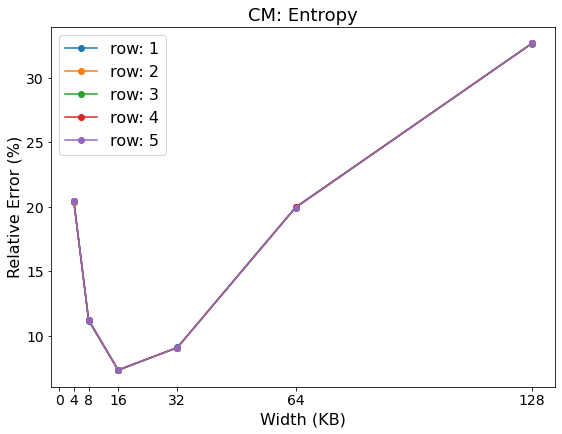

In [157]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['cm']
rows = [1, 2, 3, 4, 5]
# rows = [1]
widths = [4096, 8192, 16384, 32768, 65536, 131072]
# measure_list = ['hh', 'entropy']
measure_list = ['entropy']
flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
epochs = ['30']
datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
isSave = False
isShowByte = False

profiling_analysis(algos, rows, widths, measure_list, flowkeys, epochs, datasets, isSave, isShowByte)

In [ ]:
---

## Measure New CM

{'entropy': {1: [18.846318899302478, 14.169264802840345, 10.28025770433756, 7.202167255227802, 4.839750404952134, 3.073520646081801], 2: [18.81435900626551, 14.135006787346493, 10.269379013631754, 7.197073102511427, 4.839128184593403, 3.079490574740318], 3: [18.793256984147344, 14.128188766266755, 10.27609787019671, 7.20157504863877, 4.838442005058794, 3.084348828487709], 4: [18.78788306874836, 14.122375912137839, 10.264102456346363, 7.20050803535712, 4.836196997997685, 3.079912868931615], 5: [18.784065890775484, 14.122876697963735, 10.264083906245888, 7.204806898082954, 4.838021774726588, 3.0813941087661747]}}


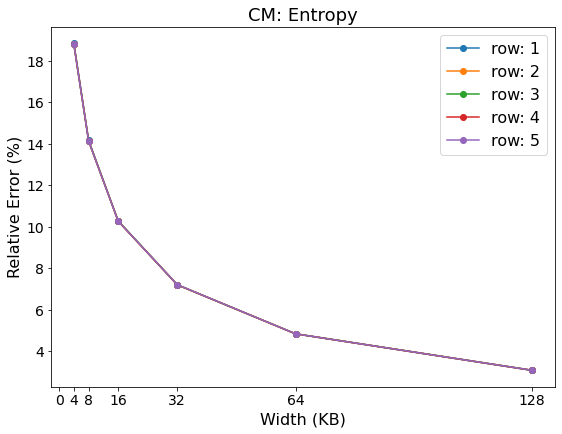

In [9]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['cm']
rows = [1, 2, 3, 4, 5]
# rows = [1]
widths = [4096, 8192, 16384, 32768, 65536, 131072]
# measure_list = ['hh', 'entropy']
measure_list = ['entropy']
flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
epochs = ['30']
datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
isSave = False
isShowByte = False

profiling_analysis(algos, rows, widths, measure_list, flowkeys, epochs, datasets, isSave, isShowByte)

---

## Measure Old CS

{'entropy': {1: [13.97212153427558, 6.325496248294816, 7.476925839530959, 17.206622005630802, 28.069604733780594, 39.104821439825024], 2: [14.038810898904188, 6.352775981015203, 7.5035542296782785, 17.157899862560452, 28.045217807517094, 39.0927536058793], 3: [14.024268506197613, 6.332633339545684, 7.495326382269766, 17.165289290102436, 28.029586069585047, 39.08626703746349], 4: [14.05615205905429, 6.387943204897674, 7.543234134503919, 17.175806204173714, 28.036862716438606, 39.094759032470165], 5: [14.07153576891386, 6.401434278602859, 7.535314325927447, 17.166731686511337, 28.0238992754617, 39.08488345575726]}}


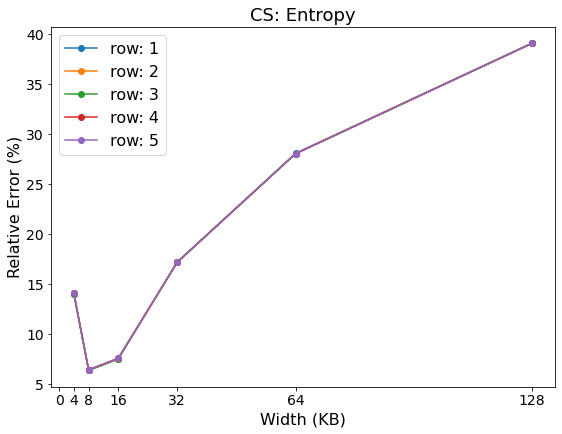

In [158]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['cs']
rows = [1, 2, 3, 4, 5]
# rows = [1]
widths = [4096, 8192, 16384, 32768, 65536, 131072]
# measure_list = ['hh', 'entropy']
measure_list = ['entropy']
flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
epochs = ['30']
datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
isSave = False
isShowByte = False

profiling_analysis(algos, rows, widths, measure_list, flowkeys, epochs, datasets, isSave, isShowByte)

In [2]:
## Measure New CS

{'entropy': {1: [23.42355188225747, 18.782707875114053, 14.79237986336886, 11.437080776788031, 8.589789133534628, 6.098123193904126], 2: [23.356958695830972, 18.725831201047026, 14.763369456365178, 11.42842481283504, 8.584403434900429, 6.097985484452468], 3: [23.340973000849782, 18.708168156565947, 14.766397282887008, 11.437244843618965, 8.578756004484646, 6.0952583774575295], 4: [23.326975985335196, 18.709900516271187, 14.763844302446008, 11.439652101834028, 8.580881587269827, 6.099036419471598], 5: [23.31987474487755, 18.699993156329683, 14.768045439292095, 11.441728626240733, 8.581337224015885, 6.099008177841024]}}


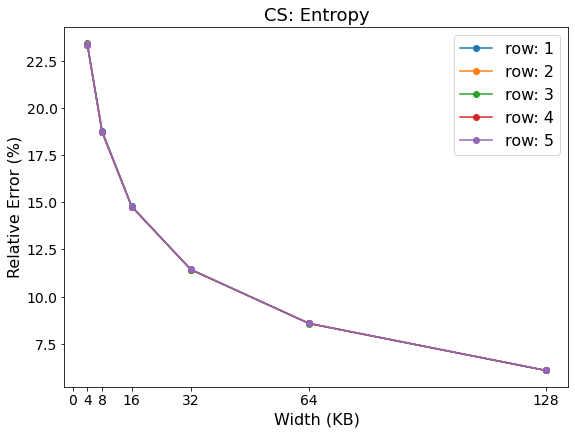

In [10]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['cs']
rows = [1, 2, 3, 4, 5]
# rows = [1]
widths = [4096, 8192, 16384, 32768, 65536, 131072]
# measure_list = ['hh', 'entropy']
measure_list = ['entropy']
flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
epochs = ['30']
datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
isSave = False
isShowByte = False

profiling_analysis(algos, rows, widths, measure_list, flowkeys, epochs, datasets, isSave, isShowByte)

In [3]:
---

## !Final Version CS Entropy!

SyntaxError: invalid syntax (<ipython-input-3-be37c8f533d0>, line 1)

{'entropy': {1: [53.194938234974785, 43.60174532773715, 34.77561539090714, 26.879376068282685, 20.195691958442207, 14.28131844501552], 2: [53.04778192096487, 43.49232408107898, 34.68967490702115, 26.8550043249721, 20.157250994381993, 14.315486001418952], 3: [53.14970420798672, 43.60383364718024, 34.7670100879212, 26.90147774229236, 20.153923668740592, 14.31671285323488], 4: [53.06078997117968, 43.51238748604476, 34.66860203078519, 26.85279647728919, 20.127964661312216, 14.312309694958344], 5: [53.06249103721522, 43.54046102756261, 34.71240240413286, 26.890637098045932, 20.131374416984755, 14.317653446510382]}}


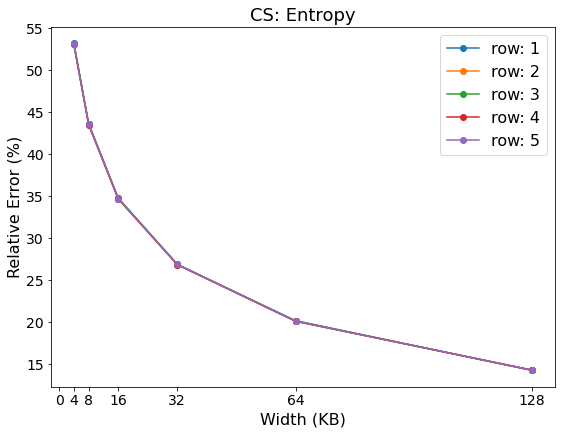

In [9]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['cs']
rows = [1, 2, 3, 4, 5]
# rows = [1]
widths = [4096, 8192, 16384, 32768, 65536, 131072]
# measure_list = ['hh', 'entropy']
measure_list = ['entropy']
flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
epochs = ['30']
datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
isSave = False
isShowByte = False

profiling_analysis(algos, rows, widths, measure_list, flowkeys, epochs, datasets, isSave, isShowByte)